The function below takes a "slice" out of a time series dataset, with the size and location of the slice being customisable. A fast fourier transform and some signal processing techniques, such as windowing, are then applied to the segment and two plots are produced: one for the original slice of the raw dataset, and one for the subsequent, fourier-transform of the raw data. Multiple datasets can be inputted into the function, allowing a side-by-side comparison of ULF waves at different magnetometer stations.
    
The customisation different slices is useful because different segments of the dataset can quickly be analysed and sifted through for ULF waves while having the raw data slice alongside the fourier transform of the same slice allows the user to observe the ULF waves from two perspectives: their more discrete, natural state, and a more precise, analytical view. Having the ability to compare multiple magnetometer station datasets side-by-side is crucial for studying the affect of differing latitutes on ULF wave activity - a major topic for my dissertation.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.fft import rfft, rfftfreq, irfft

#Data formatting function turning hhmmss to hh:mm:ss
def func(x):
    s1 = x%100
    s2 = (x//100)%100
    s3 = x//10000
    return s3*3600 + s2*60 + s1

#Defining function for use on time series.

def Fourier(TimeSeriesHeading=[], ValuesHeading=[], FileNames=[], Lowerbound = [], Upperbound = [],
            X_Axis_Label=None, Y_Axis_Label=None, Title=None, Legend_Title=None):
    fig, (ax1, ax2) = plt.subplots((2), figsize=(8, 3))
    ax2.set_title(Title)
    
    #Read the csv filename and data from csv file columns
    for ts_heading in TimeSeriesHeading:
        for vals_heading in ValuesHeading:
            for filename in FileNames:
                #Taking data from between bound parameters (input variables for the main function)       
                data = pd.read_csv(filename, sep=' ')
                time_data_1 = data[ts_heading].iloc[Lowerbound:Upperbound].map(func)
                values_data_1 = data[vals_heading].iloc[Lowerbound:Upperbound]
                values_data_1 = (values_data_1-np.mean(values_data_1))
                
                #Setting sample rate and bell window - parameters used in the fast fourier analysis function below
                sample_rate = 1/10
                bell_window = np.blackman(Upperbound-Lowerbound)
                #Setting sample size to be equal to length of input data (between the bounds inputted into function)
                N = len(time_data_1)
                
                #Compute the one-dimensional discrete Fourier Transform for real input.
                values_data_1_transformed = scipy.fft.rfft(values_data_1.values)
                #Return the Discrete Fourier Transform sample frequencies 
                sample_freq = scipy.fft.rfftfreq((N), 1/sample_rate)
                #Setting bounds of range where ULF waves occur: 3mhz-6mhz
                values_data_1_transformed[(sample_freq) < 0.003] = 0
                values_data_1_transformed[(sample_freq) > 0.006] = 0
                
                #Taking the absolute value of the fourier transform, therefore finding the magnitude of the real and imaginary parts combined
                values_data_1_transformed_irfft = irfft(np.abs(values_data_1_transformed))
                
                values_data_1_transformed_irfft_blackman = np.multiply(bell_window, values_data_1_transformed_irfft)
               
                values_data_1_transformed = np.abs(scipy.fft.rfft((values_data_1_transformed_irfft_blackman)))
                sample_freq = scipy.fft.rfftfreq((N), 1/sample_rate)
                
            
                #Overlay onto the existing plot
                ax1.plot(time_data_1, values_data_1)
                ax2.plot(sample_freq, np.abs(values_data_1_transformed),
                        label=f'{ts_heading}/{vals_heading}/{filename}')
                

    #Add legend after all graphs drawn
    
    ax1.set_ylim(-2,2)
    ax1.set_title('Raw Data (Mean-Normalised)')
    ax1.set_xlabel('Time of Day (Seconds)')
    ax2.set_ylim(0,10)
    ax2.set_title('Fast Fourier Tranform of Raw Data')
    ax2.set_xlabel('Frequency (Hz)')
    plt.xlim(0,0.007)
    plt.tight_layout()
    
    if Legend_Title == Legend_Title:
            ax2.legend(title = "Analysed Files:", loc=(1.04, 0))

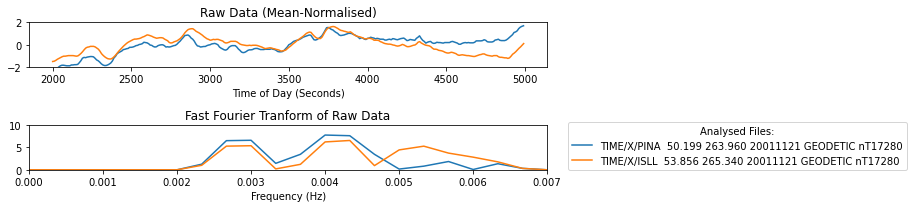

In [70]:
#Application of function, inputting our column headers first, the file names of datasets to compare and the periods between which we want to analyse
Fourier(['TIME'], ['X'], 
        ["PINA  50.199 263.960 20011121 GEODETIC nT17280","ISLL  53.856 265.340 20011121 GEODETIC nT17280"], Lowerbound = 200, Upperbound = 500)

For this specific slice of the dataset, from an index of [200] to [500], we're analysing 300 (500-200) samples of time-series data. The sample rate for this dataset was 10 seconds, therefore we're analysing a 3000 second (300/(1/10)), or 50 minute, worth slice of time-series data. 

The 50 minute segment of raw data can be seen in the top graph, with some small - undefined - waves occuring throughout. The bottom graph shows us the amplitudes and frequencies of the waves in the top graph, between 1.6 and 7 mhz - the ULF wave range. In this case, we can see waves occuring at ~ 2.8, 4.3 and 5.4 mhz.